In [1]:
import numpy as np
from myplotstyle import plt,get_figsize

%matplotlib inline

import matplotlib
import matplotlib.backends.backend_pdf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines

from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

In [2]:
# SET LOCAL VARIABLES
saga = SAGA.QuickStart()


SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
base = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101

sats = C.is_sat.filter(base)

In [4]:
ma = [i for i in sats['SPEC_REPEAT_ALL'] if 'ALFALF' in i]
print('ALFALFA detections = ', np.size(ma))
mf = [i for i in sats['SPEC_REPEAT_ALL'] if 'FASHI' in i]
print('FASHI detections   = ', np.size(mf))

print('Total HI dections  = ',np.sum(np.isfinite(sats['HI_FLUX'])))
 

ALFALFA detections =  26
FASHI detections   =  33
Total HI dections  =  61


In [5]:
##  LMC/SMC

# LOG_SM
mw_mc_sm  = np.array([np.log10(2.7e9),np.log10(3.0e8)])

# SFR
mw_mc_sfr = np.array([np.log10(0.1),np.log10(0.037)])
mw_mc_ssfr = mw_mc_sfr-mw_mc_sm

# Putnman
mw_mc_gas = np.array([np.log10(4.6e8),np.log10(4.6e8)])+ np.log10(1.4)
mw_mc_stream = np.array([np.log10(2*4.6e8),np.log10(2*4.6e8)])+ np.log10(1.4)

# Calc gas fractions
mw_mc_fgas = 10**mw_mc_gas/(10**mw_mc_gas + 10**mw_mc_sm)
mw_mc_fgas_stream = 10**mw_mc_stream/(10**mw_mc_stream + 10**mw_mc_sm)


In [6]:
mm    = np.isfinite(sats['log_MHI'])
gsats = sats[mm]

gas_fraction = 1.4*10**gsats['log_MHI']/(1.4*10**gsats['log_MHI']+10**gsats['log_sm'])
ssfr = gsats['nuv_sfr'] - gsats['log_sm']



In [7]:
def bin_median(bins,x,y, ssfr):
    
    wmedian,werr1, werr2 = [],[],[]
        
    for i,b in enumerate(bins[:-1]):
        m = (x>bins[i]) & (x<bins[i+1])
        xx = np.percentile(y[m], [16, 50, 84]) 
        
        wmedian.append(xx[1])
        werr1.append(xx[1] - xx[0])
        werr2.append(xx[2] - xx[1])
                
    return wmedian,werr1,werr2

In [8]:

# MEDIAN BINS
xx   = [8,8.5,9,9.5]
bins = [7.75,8.25,8.75,9.25,9.75]


## Calculate limits on HI Mass from HI flux limit btw 25-40 Mpc

In [9]:
# Flux limit in mJy based on FASHI and ALFALFA limits
f_lim = 0.3

d = 25
HI_lim1 = 2.356e5*(d**2)*f_lim

d=40
HI_lim2 = 2.356e5*(d**2)*f_lim


stars = np.arange(6,10.3,0.1)
fgas_lim1 = 1.4*HI_lim1/(1.4*HI_lim1 + 10**stars)
fgas_lim2 = 1.4*HI_lim2/(1.4*HI_lim2 + 10**stars)


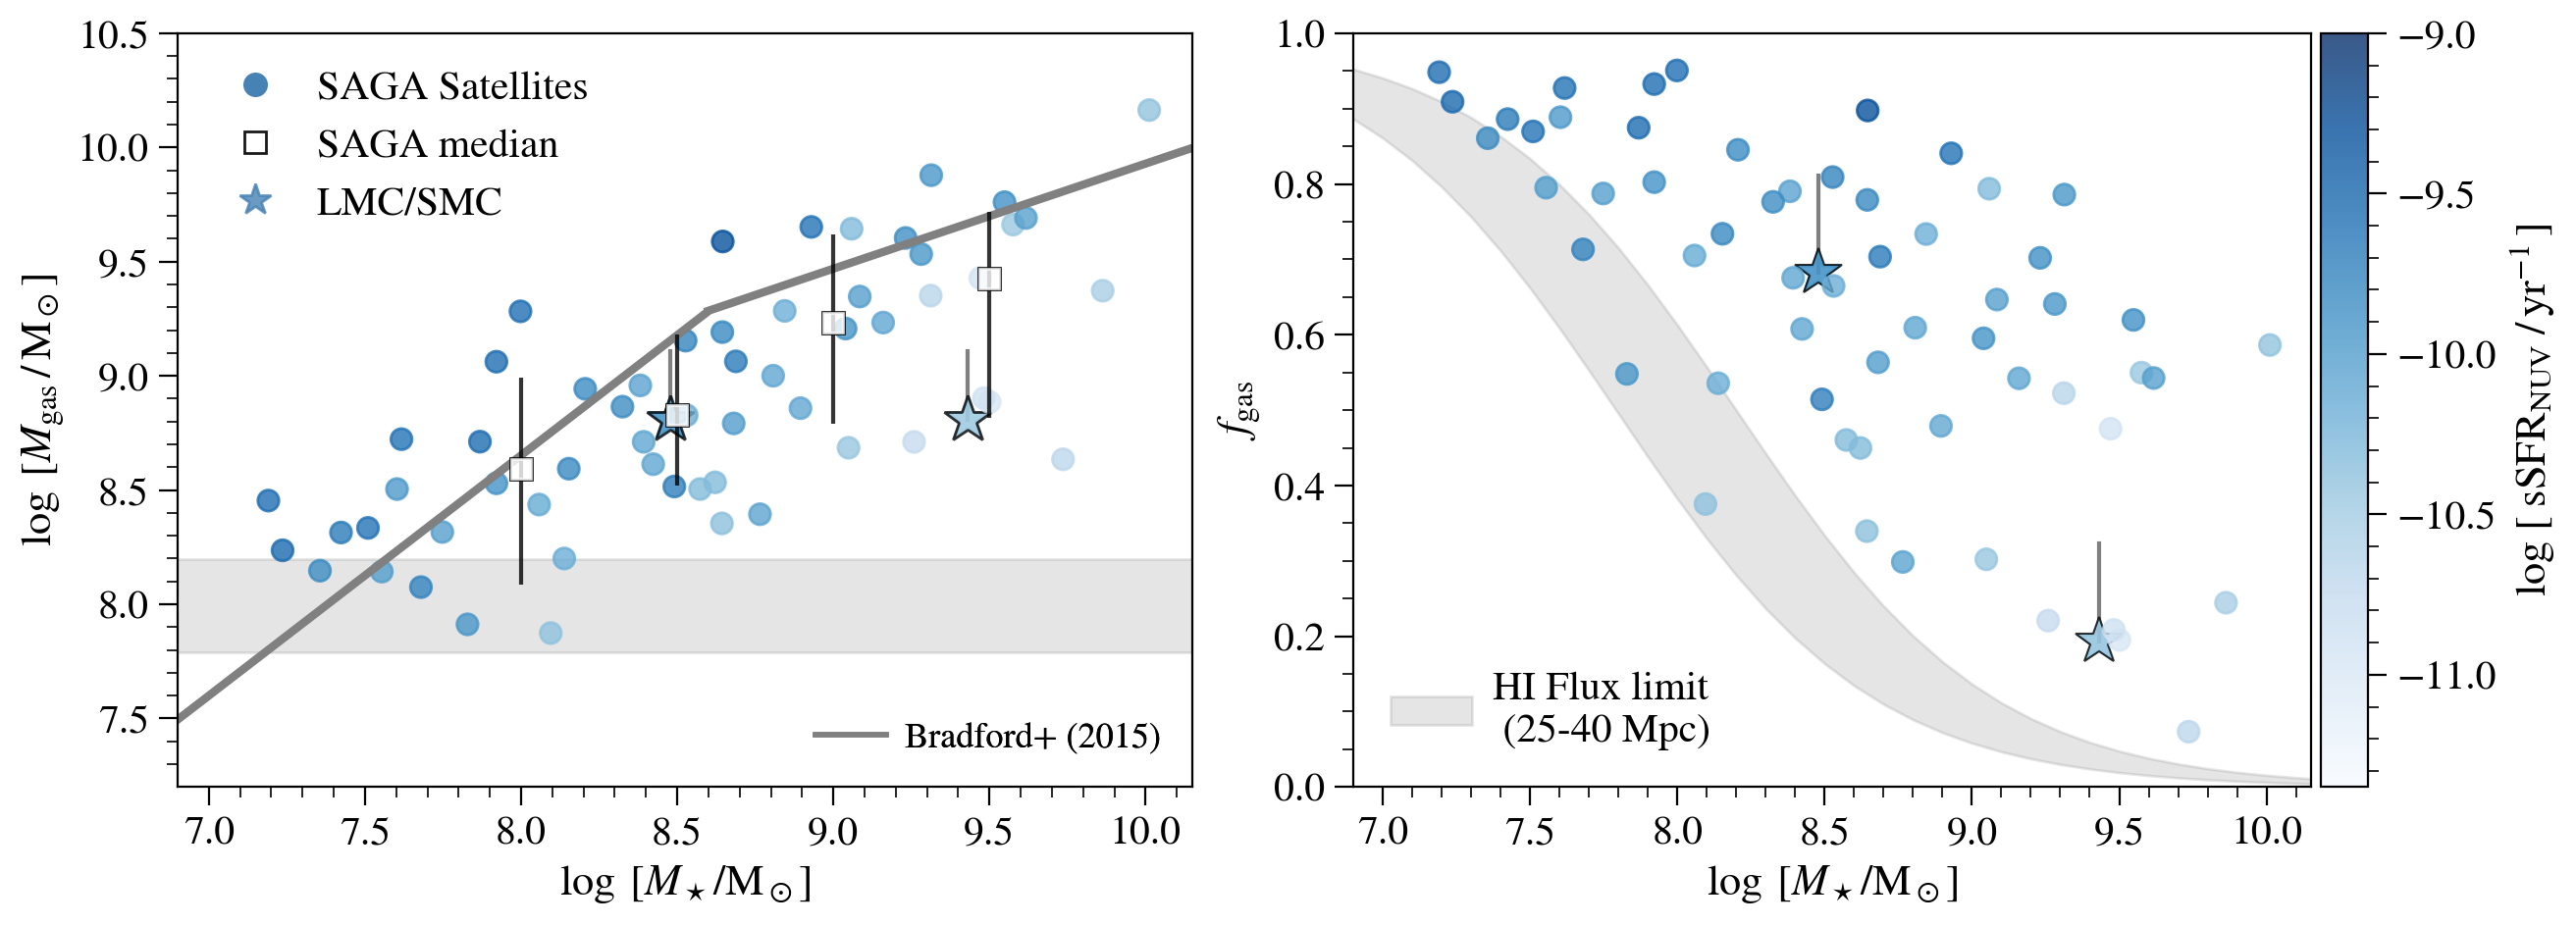

In [10]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_HI.pdf')
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=get_figsize(wide=True, ratio=2.7))


msize = 60

ax1.scatter(gsats['log_sm'],gsats['log_MHI']+np.log10(1.4),c=ssfr,alpha=0.8,vmin=-11.35,vmax=-9.,cmap='Blues',\
            label='SAGA Satellites',s=msize,zorder=2)

ax1.set_ylabel(r'$\log\;[M_{\rm gas}\,/\,{\rm M}_\odot]$')
ax1.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')


# ADD MC
s1=260
s2=18
ax1.scatter(mw_mc_sm,mw_mc_gas,marker='*',c=mw_mc_ssfr,label='LMC/SMC',vmin=-11.25,vmax=-9.,\
            s=s1,cmap='Blues',alpha=0.9,zorder=1)
ax1.plot(mw_mc_sm,mw_mc_gas,'*k',ms=s2,mfc='None',alpha=0.8,zorder=1)


# BRADFORD 2015+ uses Chabrier
x=np.arange(6.25,8.6,0.01)
y =1.052*x+0.236
ax1.plot(x,y,'grey',label='Bradford+ (2015)',lw=3)

x=np.arange(8.6,10.5,0.01)
y =0.46*x+5.329
ax1.plot(x,y,'grey',lw=3)
ax1.fill_between(stars,np.log10(HI_lim1*1.4),np.log10(HI_lim2*1.4),\
                 color='grey',alpha=0.2,label='HI Flux limit\n (25-40 Mpc)')

# Calculate medians
a,b,c = bin_median(bins,gsats['log_sm'],gsats['log_MHI']+np.log10(1.4),ssfr)

color='k'
ax1.plot(xx,a,'s',c='white',ms=7,label='SAGA median',alpha=0.8,zorder=10)
ax1.errorbar(xx,a,yerr=[b,c],ls='none',c='k',ms=8,alpha=0.8,lw=1.5,zorder=5)
ax1.plot(xx,a,'s',c='k',ms=8,alpha=0.9,mfc='none',zorder=5)


l1 = mlines.Line2D([], [], color='steelblue', marker='o', ls='', label='SAGA Satellites',ms=8)
l2 = mlines.Line2D([], [], color='k', mfc='none',marker='s', ls='', label='SAGA median',ms=8,alpha=0.9)
lc = mlines.Line2D([], [], color='steelblue', marker='*', ls='', label='LMC/SMC',ms=12,alpha=0.8)

leg1 = ax1.legend(loc='upper left',handles=[l1,l2,lc])
ax1.add_artist(leg1)

lb = mlines.Line2D([], [], color='grey', marker='', ls='-', lw=2,label='Bradford+ (2015)')
leg2 = ax1.legend(fontsize=13,loc='lower right',handles=[lb])

ax1.add_artist(leg2)
########

cm = ax2.scatter(gsats['log_sm'],gas_fraction,c=ssfr,alpha=0.8,vmin=-11.35,vmax=-9.,cmap='Blues',s=msize,zorder=2)

ax2.set_xlabel(r'$\log\;[M_\star/{\rm M}_\odot]$')
ax2.set_ylabel(r'$f_{\rm gas}$')
ax2.set_ylim(0,1)


divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(cm, cax=cax,ticks=[-11, -10.5,-10,-9.5, -9],\
             label=r'$\log \, [ \; {\rm sSFR}_{\rm NUV} \; / \, {\rm yr}^{-1} \,$]')



# ADD MC
ax2.scatter(mw_mc_sm,mw_mc_fgas,c=mw_mc_ssfr,marker='*',vmin=-11.35,vmax=-9.,\
            s=s1,cmap='Blues',alpha=0.9,zorder=1)
ax2.plot(mw_mc_sm,mw_mc_fgas,'*k',ms=s2,mfc='None',markeredgewidth=0.75,alpha=0.8,zorder=1)


ax1.plot([mw_mc_sm,mw_mc_sm],[mw_mc_gas,mw_mc_stream],'grey',zorder=0)
ax2.plot([mw_mc_sm,mw_mc_sm],[mw_mc_fgas,mw_mc_fgas_stream],'grey',zorder=0)

ax1.set_ylim(7.2,10.5)
ax1.set_xlim(6.9,10.15)
ax2.set_xlim(6.9,10.15)


ax2.fill_between(stars,fgas_lim1,fgas_lim2,color='grey',alpha=0.2,label='HI Flux limit\n (25-40 Mpc)')
ax2.legend(loc='lower left')

pdf.savefig()
pdf.close()
